This notebook aggregates team data from NFL Plays database NFLDB.db. I have previously constructed this database from the Python nflgame package https://github.com/BurntSushi/nflgame.  The function TestDB() queries the database for various statistics corresponding to teams and seasons to determine which metrics are most strongly correlated with number of wins. 

In [66]:
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import time
from sqlalchemy import create_engine
import sqlite3 as db
import warnings
warnings.filterwarnings('ignore')

def TestDB():
    conn = db.connect('NFLDB.db')
    c=conn.cursor();

    Query='SELECT * FROM  (SELECT  year, Home, count(Gamekey) hwin FROM Games WHERE Home IN (SELECT distinct Plays.Team FROM Plays)  AND  HomeScore>AwayScore AND year in (SELECT distinct year FROM Games) GROUP BY Home, year ORDER BY Home)  '
    HomeWins=c.execute(Query).fetchall()

    Query='SELECT year, Away, count(Gamekey) FROM Games WHERE Away IN (SELECT distinct Plays.Team FROM Plays)  AND  HomeScore<AwayScore AND year in (SELECT distinct year FROM Games) GROUP BY Away, year'
    AwayWins=c.execute(Query).fetchall()

    Query='SELECT year, Team, count(P.Gain), avg(Gain)   FROM Plays P, Games G WHERE P.Team IN (SELECT distinct Plays.Team FROM Plays) AND year IN (SELECT distinct year FROM Games) AND P.Down=1 AND P.ToGo=10  AND P.Gamekey=G.Gamekey GROUP BY Team, year ORDER BY Team, year'
    First10Total=c.execute(Query).fetchall()

    Query='SELECT year, Team, count(Gain) FROM Plays, Games WHERE Team IN (SELECT distinct Plays.Team FROM Plays) AND year IN (SELECT distinct year FROM Games) AND Plays.Down=1 AND Plays.ToGo=10 AND Gain>4 AND Plays.Gamekey=Games.Gamekey GROUP BY Opponent, year ORDER BY Team, year'
    First10Success=c.execute(Query).fetchall()

    Query='SELECT year, Opponent, count(Gain) FROM Plays, Games WHERE Opponent IN (SELECT distinct Plays.Opponent FROM Plays) AND year IN (SELECT distinct year FROM Games) AND Plays.Down=1 AND Plays.ToGo=10 AND Gain>4 AND Plays.Gamekey=Games.Gamekey GROUP BY Opponent, year ORDER BY Opponent, year'
    First10SuccessOpp=c.execute(Query).fetchall()

    Query='SELECT year, Opponent, count(P.Gain), avg(Gain) FROM Plays P, Games G WHERE P.Opponent IN (SELECT distinct Plays.Opponent FROM Plays) AND year IN (SELECT distinct year FROM Games) AND P.Down=1 AND P.ToGo=10  AND P.Gamekey=G.Gamekey GROUP BY Opponent, year ORDER BY Opponent, year'
    First10TotalOpp=c.execute(Query).fetchall()

    Query='SELECT year, Team, count(Gain) FROM Plays P, Games G WHERE Down=3 AND Gain>=ToGo AND Team IN (SELECT distinct Team FROM Plays) AND year IN (SELECT distinct year FROM Games) AND P.Gamekey=G.Gamekey GROUP BY Team, year ORDER BY Team, year'
    ThirdDownSuccess=c.execute(Query).fetchall()

    Query='SELECT year, Team, count(Gain) FROM Plays P, Games G WHERE Down=3 AND Team IN (SELECT distinct Team FROM Plays) AND year IN (SELECT distinct year FROM Games) AND P.Gamekey=G.Gamekey GROUP BY Team, year ORDER BY Team, year'
    ThirdDownAttempts=c.execute(Query).fetchall()

    conn.close()

    P=pd.DataFrame(HomeWins, columns=('year','Team','HomeWins'))
    PA=pd.DataFrame(AwayWins, columns=('year','Team','AwayWins'))
    First10Total=pd.DataFrame(First10Total,columns=('year','Team','First10Plays','AveGainFirst10'))
    First10Success=pd.DataFrame(First10Success,columns=('year','Team','First10Success'))
    First10SuccessOpp=pd.DataFrame(First10SuccessOpp,columns=('year','Team','First10SuccessOpp'))
    First10TotalOpp=pd.DataFrame(First10TotalOpp,columns=('year','Team','First10TotalOpp','AveGainOppFirst10'))
    ThirdDownSuccess=pd.DataFrame(ThirdDownSuccess,columns=('year','Team','ThirdDownSuccesses'))
    ThirdDownAttempts=pd.DataFrame(ThirdDownAttempts,columns=('year','Team','ThirdDownAttempts'))

    P=P.merge(PA,how='outer')
    P=P.merge(First10Total,how='outer')
    P=P.merge(First10Success,how='outer')
    P=P.merge(First10SuccessOpp,how='outer')
    P=P.merge(First10TotalOpp,how='outer')
    P=P.merge(ThirdDownSuccess,how='outer')
    P=P.merge(ThirdDownAttempts,how='outer')

    FourthDowns=PuntDrives()

    P=P.merge(FourthDowns,how='outer')
    P.to_csv('TeamAggregateData.csv')

    return P

def PuntDrives():

    conn = db.connect('NFLDB.db')
    c=conn.cursor();

    cursor = c.execute('select * from Plays')
    rowt = c.description
    colList=list()
    for i in range(len(rowt)):
        colList.append(rowt[i][0])
    print(colList)

    GetDrivesQuery='SELECT distinct PL.GameKey, PL.DriveNum, PL.c, PL.DriveResult FROM (SELECT  GameKey, DriveNum, count(Down) c, DriveResult FROM Plays WHERE Down=4  GROUP BY GameKey, DriveNum) PL  WHERE  DriveResult != "Punt" AND DriveResult != "Field Goal" AND DriveResult != "Missed FG" AND DriveResult != "Blocked Punt" AND DriveResult != "End of Half"  AND DriveResult != "Blocked FG" AND DriveResult != "End of Game" OR c>1'

    GetPlaysQuery='SELECT  Plays.ToGo ToGo, Plays.Team Team , dq.Gamekey Gamekey, dq.DriveNum DriveNum, Plays.FieldPosition FieldPosition, Plays.DriveResult DriveResult, Plays.Gain Gain  FROM ' + '(' + GetDrivesQuery +' ) dq, Plays WHERE dq.DriveNum=Plays.DriveNum AND dq.GameKey=Plays.Gamekey AND Down=4'

    GetNonPunt='SELECT gpq.DriveResult,  gpq.Team Team, gpq.GameKey, gpq.FieldPosition FieldPosition, gpq.Gain Gain, gpq.DriveNum DriveNum, gpq.ToGo ToGo FROM ' + '(' + GetPlaysQuery + ') gpq WHERE DriveResult != "Punt" AND DriveResult != "Field Goal" AND DriveResult != "Missed FG" AND DriveResult != "Blocked Punt"  AND DriveResult != "Blocked FG" OR Gain>ToGo'

    GetNonPunt2='SELECT gnp.Gamekey Gamekey, Team, Gain, DriveNum, ToGo, year, DriveResult FROM ( ' + GetNonPunt + ') gnp, Games WHERE GAMES.Gamekey=gnp.Gamekey'

    TotalSuccess='SELECT * FROM ((SELECT  count(Gamekey) Convers FROM (' + GetNonPunt2 + ') WHERE Gain>ToGo), (SELECT count(Gamekey) Attempt FROM (' +GetNonPunt2 + '))) '

    GroupTeamYear='SELECT Team, year, FourthAttempt, FourthSuccess FROM ((SELECT Team, year, count(Gamekey) FourthAttempt FROM (' + GetNonPunt2 + ')  GROUP BY Team, year), (SELECT  Team Team2, year year2, count(Gamekey) FourthSuccess FROM (' + GetNonPunt2 + ') WHERE ToGo<=Gain GROUP BY Team, year)) WHERE Team2=Team AND year=year2'

    S=c.execute(GroupTeamYear)
    ColNames=S.description
    colList=list()
    for i in range(len(ColNames)):
        colList.append(ColNames[i][0])
    print(colList)

    FourthDownAttempts=S.fetchall()
    FourthDownAttempts=pd.DataFrame(FourthDownAttempts,columns=colList)

    return FourthDownAttempts

def TeamYearCorr():
    HW=TestDB()
    HW.HomeWins[np.isnan(HW.HomeWins)]=0
    HW.AwayWins[np.isnan(HW.AwayWins)]=0
    HW['FourthRate']=HW.FourthSuccess/HW.FourthAttempt
    HW['ThirdRate']=HW.ThirdDownSuccesses/HW.ThirdDownAttempts
    HW['FirstRate']=HW.First10Success/HW.First10Plays
    HW['TotalWins']=HW.HomeWins+HW.AwayWins

    A=np.transpose(np.array(HW[HW.columns[4:]]))
    CC=np.corrcoef(A)
    Param=HW.columns[4:-1]
    C = dict()

    for i in range(len(Param)):
        C[Param[i]]=CC[-1,i]
        print(str(Param[i]) +' : '+ str(CC[-1,i]))
    return HW

t=time.time()
HW=TeamYearCorr()
print(str(time.time()-t) + ' seconds to query')

Populating the interactive namespace from numpy and matplotlib
['index', 'Down', 'ToGo', 'Success', 'Team', 'DriveResult', 'DriveStart', 'FieldPosition', 'GameKey', 'Opponent', 'DriveNum', 'Gain']
['Team', 'year', 'FourthAttempt', 'FourthSuccess']
First10Plays : 0.307361994333
AveGainFirst10 : 0.457625012735
First10Success : 0.0301546451853
First10SuccessOpp : -0.179319807885
First10TotalOpp : -0.0955178032684
AveGainOppFirst10 : -0.280355472952
ThirdDownSuccesses : 0.397591494146
ThirdDownAttempts : -0.193955642291
FourthAttempt : -0.516192086033
FourthSuccess : -0.210276449966
FourthRate : 0.261207993403
ThirdRate : 0.511317772884
FirstRate : -0.130728721947
7.07008290291 seconds to query


We will now attempt to compute a linear regression prediction for the number of wins an NFL team will achieve based on in-game statistics. The Pandas dataframe HW contains aggregated team information as well as the number of wins for a team in a given year. The regression will use 90% of the team seasons from 2009-2015 to train the model, and 10% for testing. 

1.94405297517
1.61498872436


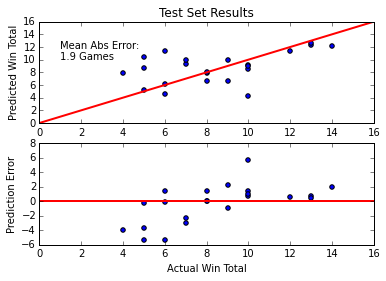

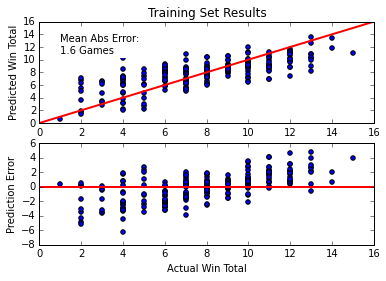

In [65]:
from sklearn.linear_model import LinearRegression

def FootballRegression(DF,TestFrac):
    lm=LinearRegression()
    X=np.array(DF[DF.columns[4:-1]])
    Y=np.array(DF.TotalWins)
    
    TestRand=np.array(np.floor(np.random.rand(len(Y)*TestFrac)*len(Y)),dtype=int)
    TestX=X[TestRand]
    TestY=Y[TestRand]
    
    XTrain=np.delete(X,TestRand,axis=0)
    YTrain=np.delete(Y,TestRand,axis=0)
    
    lm.fit(XTrain,YTrain)
    PRE=lm.predict(TestX)
    ERRTest=np.mean(np.abs(PRE-TestY))
    print(ERRTest)
    
    plt.subplot(2,1,1)
    plt.scatter(TestY,PRE)
    plt.plot([0,16],[0,16],c='red',lw=2)
    plt.xlim([0,16])
    plt.ylim([0,16])
    plt.ylabel('Predicted Win Total')
    plt.xlabel('Actual Win Total')
    plt.title('Test Set Results')
    plt.text(1,10,'Mean Abs Error: \n'+ str(np.round(ERRTest,decimals=1)) +' Games' ,backgroundcolor='w' )
    
    plt.subplot(2,1,2)
    plt.scatter(TestY,-PRE+TestY)
    plt.xlim([0,16])
    plt.xlabel('Actual Win Total')
    plt.ylabel('Prediction Error')
    plt.plot([0,16],[0,0],c='red',lw=2)
    
    LMAll=LinearRegression()
    LMAll.fit(XTrain,YTrain)

    PRETrain=LMAll.predict(XTrain)
    ERRTrain=np.mean(np.abs(PRETrain-YTrain))
    print(ERRTrain)
    plt.figure()
    plt.subplot(2,1,1)
    plt.scatter(YTrain,PRETrain)
    plt.plot([0,16],[0,16],c='red',lw=2)
    plt.xlim([0,16])
    plt.ylim([0,16])
    plt.ylabel('Predicted Win Total')
    plt.xlabel('Actual Win Total')
    plt.title('Training Set Results')
    plt.text(1,11,'Mean Abs Error: \n'+ str(np.round(ERRTrain,decimals=1)) +' Games' ,backgroundcolor='w' )

    plt.subplot(2,1,2)
    plt.scatter(YTrain,-PRETrain+YTrain)
    plt.xlim([0,16])
    plt.xlabel('Actual Win Total')
    plt.ylabel('Prediction Error')
    plt.plot([0,16],[0,0],c='red',lw=2)

    
    return X
X=FootballRegression(HW,0.1)